In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import glob
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os

Using TensorFlow backend.


In [2]:
if not os.path.exists('JPEGImages'):
    raise Exception('No JPEGImages folder found')

In [3]:
if not os.path.isfile('labels.csv'):
    raise Exception('No labels.csv file found')

In [4]:
label = pd.read_csv('labels.csv')

In [6]:
label = label[['Image','Category']]

In [7]:
label.head()

,Image,Category
0,0,NEUTROPHIL
1,1,NEUTROPHIL
2,2,NEUTROPHIL
3,3,NEUTROPHIL
4,4,NEUTROPHIL


In [8]:
label.Category.value_counts()

NEUTROPHIL                207
EOSINOPHIL                 88
LYMPHOCYTE                 33
MONOCYTE                   21
BASOPHIL                    3
NEUTROPHIL, NEUTROPHIL      3
NEUTROPHIL, EOSINOPHIL      2
LYMPHOCYTE, LYMPHOCYTE      1
NEUTROPHIL,NEUTROPHIL       1
MONOCYTE, LYMPHOCYTE        1
EOSINOPHIL,EOSINOPHIL       1
NEUTROPHIL, LYMPHOCYTE      1
NEUTROPHIL,BASOPHIL         1
EOSINOPHIL, EOSINOPHIL      1
NEUTROPHIL,EOSINOPHIL       1
NEUTROPHIL, MONOCYTE        1
EOSINOPHIL, LYMPHOCYTE      1
Name: Category, dtype: int64

In [9]:
label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 2 columns):
Image       411 non-null int64
Category    367 non-null object
dtypes: int64(1), object(1)
memory usage: 6.5+ KB


In [11]:
label.Category.isnull().sum()
# There are 44 rows without labels, we need to clean this.

44

In [13]:
#Removing rows without labels
label_clean = label[label.Category.notnull()]

In [14]:
# Creating classes, getting rid of pictures with more than one subtype of wbc, and basophil
classes = list(label.Category.value_counts().head(4).index)

In [16]:
label_clean['classes'] = label_clean.Category.apply(lambda x: x in classes)

C:\Users\shuaix\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
label_clean = label_clean[label_clean.classes == True]

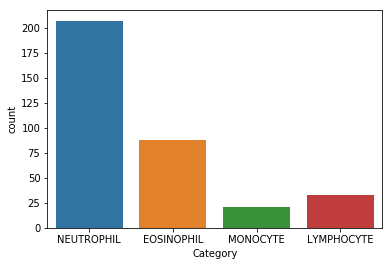

In [19]:
sns.countplot(data = label_clean, x = 'Category')
plt.show()

In [23]:
# writing function that creates the path to the file, so image column matches the image file name
def to_str(image_number):
    sn = str(image_number)
    if len(sn) == 1:
        return 'JPEGImages/BloodImage_0000'+sn+'.jpg'
    if len(sn) == 2:
        return 'JPEGImages/BloodImage_000'+sn+'.jpg'
    else:
        return 'JPEGImages/BloodImage_00'+sn+'.jpg'

In [24]:
label_clean['ImagePath'] = label_clean.Image.apply(to_str)

In [26]:
imgdf = label_clean[['ImagePath','Category']]

In [27]:
imgdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349 entries, 0 to 410
Data columns (total 2 columns):
ImagePath    349 non-null object
Category     349 non-null object
dtypes: object(2)
memory usage: 18.2+ KB


In [28]:
imgdf.head()

,ImagePath,Category
0,JPEGImages/BloodImage_00000.jpg,NEUTROPHIL
1,JPEGImages/BloodImage_00001.jpg,NEUTROPHIL
2,JPEGImages/BloodImage_00002.jpg,NEUTROPHIL
3,JPEGImages/BloodImage_00003.jpg,NEUTROPHIL
4,JPEGImages/BloodImage_00004.jpg,NEUTROPHIL


In [29]:
# removing dead paths (images not in the dataset)
imgdf.drop(index=[280],inplace = True)
imgdf.drop(index=[116],inplace = True)

C:\Users\shuaix\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [30]:
#importing the paths of all images in the dataset
images =list(glob.glob("JPEGImages/*.jpg"))

In [31]:
#creating folders for classes
folders = ['NEUTROPHIL','MONOCYTE','EOSINOPHIL','LYMPHOCYTE']
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [32]:
# renaming images and saving them to seperate folders
# create folders in the same directory as this notebook:
 
from PIL import Image
for subtype in classes:
    for path in list(imgdf.ImagePath[imgdf.Category == subtype].values):
        img  = Image.open(path)
        img.save('{}/{}_{}'.format(subtype,subtype,path[-7:]))

In [34]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True, vertical_flip = True,
        fill_mode='constant')

In [35]:
neutro = list(glob.glob("NEUTROPHIL/*.jpg"))
eosino = list(glob.glob("EOSINOPHIL/*.jpg"))
mono = list(glob.glob("MONOCYTE/*.jpg"))
lympho = list(glob.glob("LYMPHOCYTE/*.jpg"))

In [36]:
#create folder for transformation
if not os.path.exists('transformed'):
        os.makedirs('transformed')

In [37]:
# number of iterations
n_it = 15
e_it = 36
l_it = 96
m_it= 180

In [42]:
#image augumantion for neutrophils
for path in neutro:
    img = load_img(path)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, width, height)
    x = x.reshape((1,) + x.shape)
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir='transformed/NEUTROPHIL', save_prefix='aug_neu_', save_format='jpeg'):
        i += 1
        if i > n_it:
            break  

In [43]:
#image augumantion for eosinophils
for path in eosino:
    img = load_img(path)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, width, height)
    x = x.reshape((1,) + x.shape)
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir='transformed/EOSINOPHIL', save_prefix='aug_eos_', save_format='jpeg'):
        i += 1
        if i > e_it:
            break

In [44]:
#image augumantion for lymphocites
for path in lympho:
    img = load_img(path)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, width, height)
    x = x.reshape((1,) + x.shape)
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir='transformed/LYMPHOCYTE', save_prefix='aug_lym_', save_format='jpeg'):
        i += 1
        if i > l_it:
            break  

In [45]:
#image augumantion for monocites
for path in mono:
    img = load_img(path)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, width, height)
    x = x.reshape((1,) + x.shape)
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir='transformed/MONOCYTE', save_prefix='aug_mon_', save_format='jpeg'):
        i += 1
        if i > m_it:
            break  

In [46]:
img_aug = pd.DataFrame([n_it*len(neutro),m_it*len(mono),l_it*len(lympho),e_it*len(eosino)], index =["NEUTROPHIL",'MONOCYTE','LYMPHOCYTE','EOSINOPHIL'],columns=['count'])

In [48]:
img_aug

,count
NEUTROPHIL,3090
MONOCYTE,3600
LYMPHOCYTE,3168
EOSINOPHIL,3168


In [52]:
img_aug

,count
NEUTROPHIL,3090
MONOCYTE,3600
LYMPHOCYTE,3168
EOSINOPHIL,3168
